## gwresonance demo

This is a very brief tutorial on how to use the code `gwresonance`.
As an example, we will calculate the GW-induced orbital evolution of the Hulse-Taylor binary pulsar.

In [1]:
from gwresonance import *

import numpy as np
import matplotlib.pyplot as plt

First, let's define the stochastic GW spectrum $\Omega_\mathrm{gw}(f)$ we are studying. This can be any function of frequency (which is assumed to be in units of Hz). Here we'll use a peaked, phase-transition-like signal, with a peak amplitude of $\Omega_\mathrm{gw}=10^{-5}$ at $f_\mathrm{peak}=10^{-4}\,\mathrm{Hz}$.

In [2]:
def omega_gw(f):
    f_peak = 1.e-4
    return 1.e-5 * (f/f_peak)**3. * ((4. + 3.*(f/f_peak)**2.) / 7.)**-3.5

Text(0, 0.5, '$\\Omega_\\mathrm{gw}(f)$')

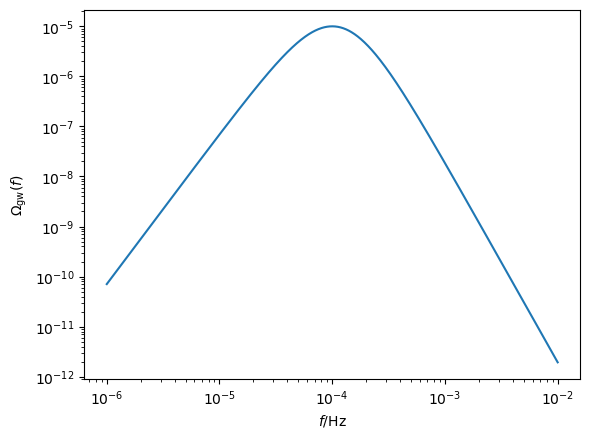

In [3]:
freqs = np.logspace(-6., -2., 1000)
plt.loglog(freqs, omega_gw(freqs))
plt.xlabel(r'$f/\mathrm{Hz}$')
plt.ylabel(r'$\Omega_\mathrm{gw}(f)$')

Now we initialiase our binary pulsar, which is an instance of the `Binary` class. The essential inputs are the GW spectrum (`sgwb`), the initial orbital elements (`x_init`), and the masses of the pulsar and its companion in solar units (`m1` and `m2`). Note that the initial period is specified in units of seconds; one can use the constants `DAY=8.64e+4` and `YR=3.15576e+7` for convenience.

The orbital elements should be specified as an array of length 6, although if there are elements we are not interested in then we can tell the code to ignore these by setting their initial values to `None`. (Some combinations of orbital elements are not allowed, and will throw a `ValueError`; see docstrings for details.)

In [4]:
ht = Binary(sgwb=omega_gw,
            x_init=[0.322997 * DAY,
                    0.617134,
                    0.752474,
                    2. * np.pi * np.random.rand(),
                    5.105865,
                    2. * np.pi * np.random.rand(),
                   ],
            m1=1.438,
            m2=1.390,
            )

The six orbital elements are always listed in the same order. We can keep track of which is which by calling the `elements` attribute of the class instance.

In [5]:
print('The orbital elements of this binary are:\n', ht.elements)

The orbital elements of this binary are:
 ['Period' 'Eccentricity' 'Inclination' 'Longitude of ascending node'
 'Argument of pericentre' 'Compensated mean anomaly']


The initial values we passed are stored as `x0`.

In [6]:
print('Initial orbital elements:\n', ht.x0)

Initial orbital elements:
 [[2.79069408e+04 6.17134000e-01 7.52474000e-01 2.68970466e+00
  5.10586500e+00 4.78571554e-01]]


We want to evolve this binary forward over time and see how its orbital elements respond to the GW background. There are two ways we can do this: evolve individual random trajectories using `evolve_langevin`, or evolve the distribution function describing these trajectories using `evolve_fokker_planck`.

## Fokker-Planck evolution

Let's start with `evolve_fokker_planck`. This has an argument `t_stop` specifying how long to evolve for (measured in seconds.) The default is to evaluate the solution at 1000 equally-spaced points in time, but one can specify something different using `t_eval`.

In [7]:
ht.evolve_fokker_planck(t_stop=50. * YR)

The exact values of the resulting orbital elements are not known, due to the stochastic nature of the GW forcing term. Instead, they are specified by some distribution function, which we assume to be Gaussian. (One can prove that this is a good assumption on observational timescales.)

This Gaussian is described by the background solution (i.e. what the orbital elements would be if there were no gravitational wave background), the perturbation of the mean with respect to this background solution, and the covariance matrix of the orbital elements, which are all functions of time. These are saved in `x0`, `dx`, and `cov` respectively. These are arrays of shape `(nt, 6)`, `(nt, 6)`, and `(nt, 6, 6)`, where `nt` is the number of time steps in the evolution. These times are saved in `t`.

In [8]:
print('Time step array has shape', ht.t.shape)
print('Background solution array has shape', ht.x0.shape)
print('Mean shift array has shape', ht.dx.shape)
print('Covariance array has shape', ht.cov.shape)

Time step array has shape (1000,)
Background solution array has shape (1000, 6)
Mean shift array has shape (1000, 6)
Covariance array has shape (1000, 6, 6)


We can access the quantities we are interested in by taking slices of these arrays. For example, the plots below show the drift in the mean orbital period, the variance of the orbital period, and the covariance of the inclination with the longitude of ascending node, all as functions of time.

Text(0, 0.5, '$\\delta\\bar{P}/\\mathrm{day}$')

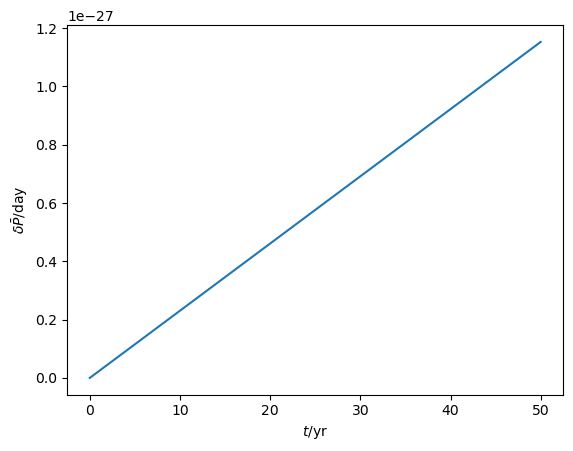

In [9]:
plt.plot(ht.t/YR, ht.dx[:, 0]/DAY)
plt.xlabel(r'$t/\mathrm{yr}$')
plt.ylabel(r'$\delta\bar{P}/\mathrm{day}$')

Text(0, 0.5, '$\\mathrm{Var}[P/\\mathrm{day}]$')

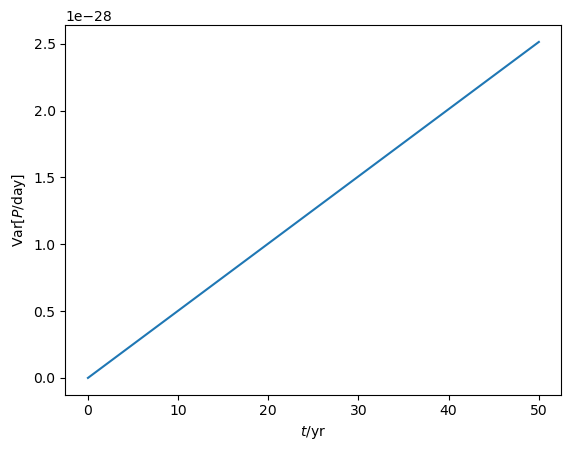

In [10]:
plt.plot(ht.t/YR, ht.cov[:, 0, 0]/DAY**2.)
plt.xlabel(r'$t/\mathrm{yr}$')
plt.ylabel(r'$\mathrm{Var}[P/\mathrm{day}]$')

Text(0, 0.5, '$\\mathrm{Cov}[I,\\Omega]$')

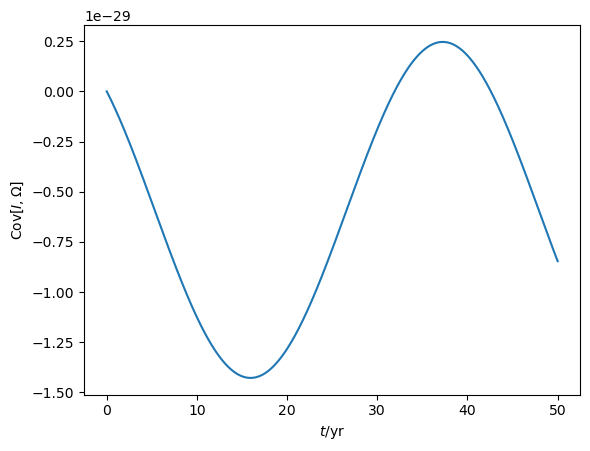

In [11]:
plt.plot(ht.t/YR, ht.cov[:, 2, 3])
plt.xlabel(r'$t/\mathrm{yr}$')
plt.ylabel(r'$\mathrm{Cov}[I,\Omega]$')

## Langevin evolution

Now let's simulate some individual random walks from this ensemble using `evolve_langevin`. We must once again specify how long to evolve for, `t_stop`. We can also specify how many random walks we'd like via the `n_walks` (default is 1). Here we'll choose 10.

In [12]:
ht.evolve_langevin(t_stop=50. * YR, n_walks=10)

Evolving random walks: 100%|██████████████████████████████████████████████████████| 999/999 [00:05<00:00, 184.28it/s]


Note that running this has now erased the Fokker-Planck solution we found before: the `dx` and `cov` attributes have now been reset to their default starting values at time zero.

In [13]:
print('Mean shift array has shape', ht.dx.shape)
print('Covariance array has shape', ht.cov.shape)

Mean shift array has shape (1, 6)
Covariance array has shape (1, 6, 6)


Instead, the random walk solutions are now saved in `walks`, which has shape `(nt, 6, n_walks)`, where `nt` is the number of time steps.

Note that the values stored in `walks` are perturbations away from the background evolution of the binary (i.e. what the orbital elements would be if there was no gravitational-wave background). This background solution is stored in `x0`, and the time is stored in `t`, as before.

In [14]:
print('Time step array has shape', ht.t.shape)
print('Background solution array has shape', ht.x0.shape)
print('Random walk array has shape', ht.walks.shape)

Time step array has shape (1000,)
Background solution array has shape (1000, 6)
Random walk array has shape (1000, 6, 10)


We can now extract information about the random walks by taking slices of `walks`. For example, the plots below show the evolution of the period over time, and trajectories in the eccentricity-inclination plane.

Text(0, 0.5, '$\\delta P/\\mathrm{day}$')

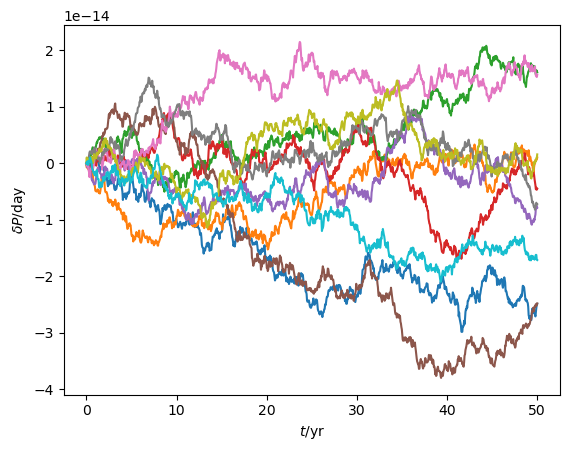

In [15]:
plt.plot(ht.t/YR, ht.walks[:, 0, :]/DAY)
plt.xlabel(r'$t/\mathrm{yr}$')
plt.ylabel(r'$\delta P/\mathrm{day}$')

Text(0, 0.5, '$\\delta I$')

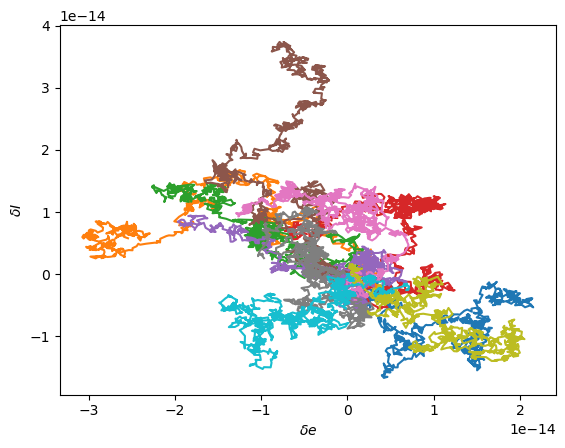

In [16]:
plt.plot(ht.walks[:, 1, :], ht.walks[:, 2, :])
plt.xlabel(r'$\delta e$')
plt.ylabel(r'$\delta I$')